In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy as np
import random
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1 import InteractiveSession, ConfigProto
plt.style.use('seaborn')

In [3]:
#GPU Einstellung, sonst klappt es bei Melvin nicht
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
#Dictionary mit allen .json
FILES = {1: 'Gangart.json',
        2 : 'Vegan.json',
        3 : 'Laender.json',
        #sonstige : 'Sonstige.json',
        4 : 'Mahlzeit.json'}

#Hyperparameter festlegen
CURRENT_FILE = FILES[2]
DROPOUT_RATE = 0.5
WITH_DIRECTIONS = False
LOSS_FUNCTION = 'categorical_crossentropy'
OPTIMIZER = 'adam'
BATCH_SIZE = 64
EPOCHS = 7

In [7]:
DATA_PATH = '../Data/'
#Load Data
with open(DATA_PATH + CURRENT_FILE) as file:
    data = json.load(file)

#Unique Zutaten erstellen
file = open(DATA_PATH + "Unique_Zutaten_clean.txt", "r") 
unique_zutaten = []
for l in file.readlines():
    as_list = l.split("\n")
    unique_zutaten.append(as_list[0])

In [8]:
#Input-und Outpus Vektoren
input_data = []
labels = []

#Dictionaries
index_zutaten = dict()
index_kategorien = dict()  
index_anweisungen = dict()

#Create Dict for Ingredients and Categories with index as value
def createDict():
    #Ingredients
    counter = 0
    for zutat in unique_zutaten:
        if zutat not in index_zutaten:
            index_zutaten[zutat] = counter
            counter +=1
        
    #Categories
    counter = 0
    for recipe in data:
        category = recipe['category']
        if category not in index_kategorien:
            index_kategorien[category] = counter
            counter +=1  
            
        #Directions
        if WITH_DIRECTIONS: 
            counterTwo = len(index_zutaten)
            anweisungen = recipe['directions_list']
            for anweisung in anweisungen:
                if anweisung not in index_anweisungen:
                    index_anweisungen[anweisung] = counterTwo
                    counterTwo +=1
    
#Create Input Vector and Output Vector (OneHot)
def createDataAndLabel():
    for recipe in data:
        ingredients = recipe['ingredients']
        category = recipe['category']
        
        #Input Vector
        inputVector = np.zeros(len(index_zutaten) + len(index_anweisungen))
        for zutat in ingredients:
            if zutat in unique_zutaten:
                inputVector[index_zutaten[zutat]] = 1
           
        #Anweisungen
        if WITH_DIRECTIONS:
            anweisungen = recipe['directions_list']
            for anweisung in anweisungen:
                inputVector[index_anweisungen[anweisung]] = 1
        input_data.append(inputVector)
        
        #Output Vector
        outputVector = np.zeros(len(index_kategorien))
        outputVector[index_kategorien[category]] = 1
        labels.append(outputVector)
        

createDict()
createDataAndLabel()

input_data = np.array(input_data)
INPUT_SHAPE = len(index_zutaten) + len(index_anweisungen)

In [9]:
#Daten 80:20 splitten und als np-array speichern
train_data, test_data, train_label, test_label = train_test_split(input_data, labels, test_size=0.2, random_state=42)

train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [10]:
def createModel():
    model = Sequential()
    model.add(Dense(256, input_dim=INPUT_SHAPE, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(len(index_kategorien), activation='softmax'))
    model.compile(loss=LOSS_FUNCTION,optimizer=OPTIMIZER, metrics=['accuracy'])
    return model

In [13]:
model = createModel()
print('Anzahl Daten zum Trainieren und Testen: ' + str(len(data)))
print()
history = model.fit(train_data,train_label, verbose=2,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(test_data, test_label))

Anzahl Daten zum Trainieren und Testen: 3279

Epoch 1/7
41/41 - 4s - loss: 0.8717 - accuracy: 0.6073 - val_loss: 0.6676 - val_accuracy: 0.7607
Epoch 2/7
41/41 - 0s - loss: 0.5972 - accuracy: 0.7758 - val_loss: 0.4892 - val_accuracy: 0.8155
Epoch 3/7
41/41 - 0s - loss: 0.4559 - accuracy: 0.8223 - val_loss: 0.4518 - val_accuracy: 0.8232
Epoch 4/7
41/41 - 0s - loss: 0.3891 - accuracy: 0.8406 - val_loss: 0.4294 - val_accuracy: 0.8338
Epoch 5/7
41/41 - 0s - loss: 0.3329 - accuracy: 0.8597 - val_loss: 0.4361 - val_accuracy: 0.8384
Epoch 6/7
41/41 - 0s - loss: 0.2841 - accuracy: 0.8856 - val_loss: 0.4434 - val_accuracy: 0.8323
Epoch 7/7
41/41 - 0s - loss: 0.2404 - accuracy: 0.9131 - val_loss: 0.4650 - val_accuracy: 0.8232


In [17]:
#Save Model
currentModel = CURRENT_FILE[0:len(CURRENT_FILE)-5]
model.save(DATA_PATH + 'Model/' + currentModel)

INFO:tensorflow:Assets written to: ../Data/Model/Vegan\assets


In [18]:
#Load Model
model = keras.models.load_model(DATA_PATH + 'Model/' + currentModel)

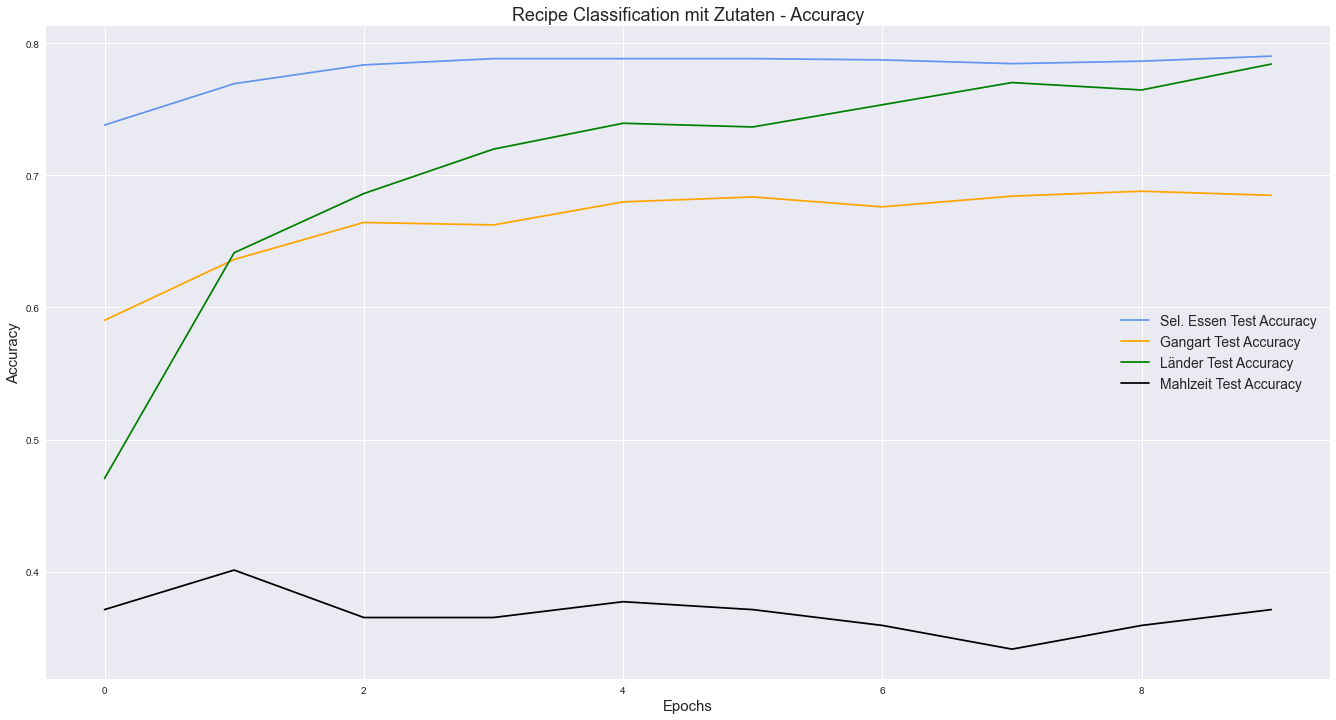

In [41]:
#Ergebnisse plotten
p = plt.figure(figsize=(23,12))
plt.plot(histories['Vegan'].history['val_accuracy'],label='Sel. Essen Test Accuracy',color='cornflowerblue')
plt.plot(histories['Gangart'].history['val_accuracy'],label='Gangart Test Accuracy',color='orange')
plt.plot(histories['Laender'].history['val_accuracy'],label='Länder Test Accuracy',color='green')
plt.plot(histories['Mahlzeit'].history['val_accuracy'],label='Mahlzeit Test Accuracy',color='black')
#plt.plot(history.history['loss'],label='Training Loss')
#plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Recipe Classification mit Zutaten - Accuracy',fontsize=18)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=14)

p.savefig("RecipeClassificationAccuracy.png", bbox_inches='tight', dpi=600)

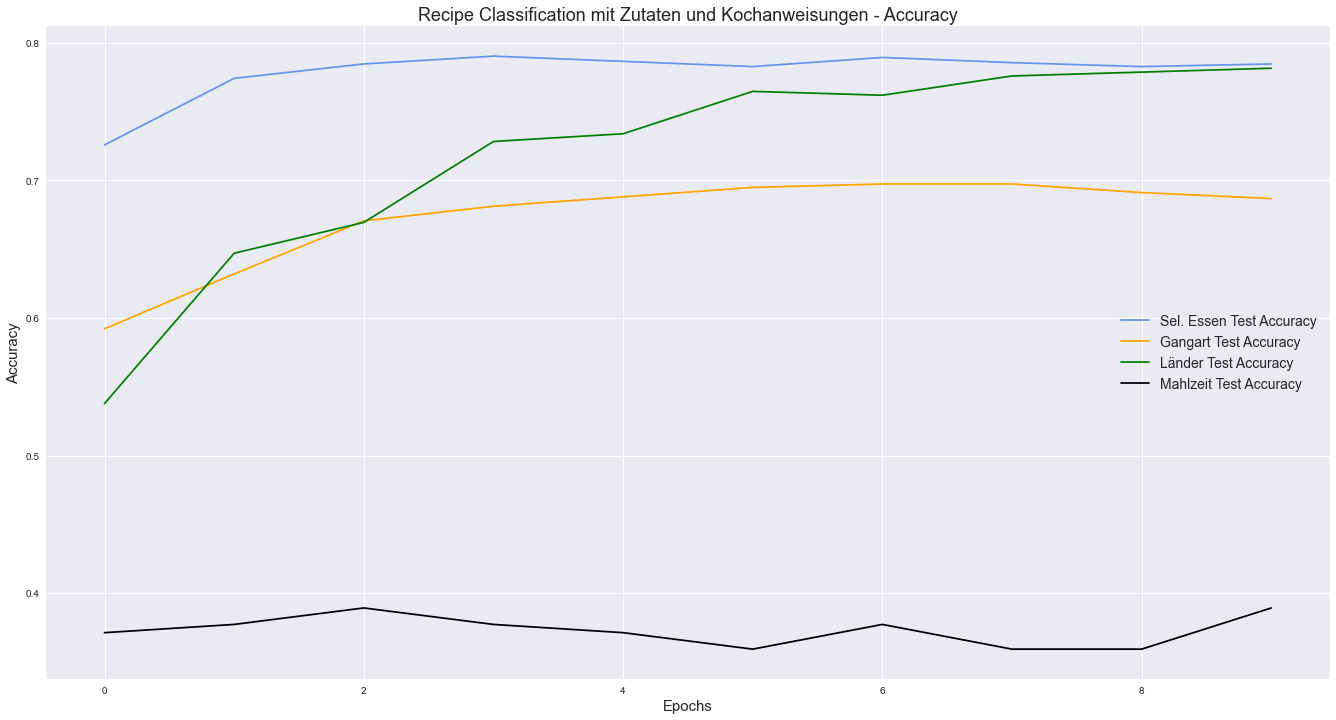

In [103]:
p = plt.figure(figsize=(23,12))
plt.plot(historyKochanweisungen['Vegan'].history['val_accuracy'],label='Sel. Essen Test Accuracy',color='cornflowerblue')
plt.plot(historyKochanweisungen['Gangart'].history['val_accuracy'],label='Gangart Test Accuracy',color='orange')
plt.plot(historyKochanweisungen['Laender'].history['val_accuracy'],label='Länder Test Accuracy',color='green')
plt.plot(historyKochanweisungen['Mahlzeit'].history['val_accuracy'],label='Mahlzeit Test Accuracy',color='black')
#plt.plot(history.history['loss'],label='Training Loss')
#plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('Recipe Classification mit Zutaten und Kochanweisungen - Accuracy',fontsize=18)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=14)

p.savefig("RecipeClassificationIngredientsAccuracy.png", bbox_inches='tight', dpi=600)